In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from SATM.preprocess import merge_aves_df
# merging train and val dataset to perform a train val test split
#df = pd.concat([json2df("train_2017_bboxes.json"), json2df("val_2017_bboxes.json")])
df = merge_aves_df("train_2017_bboxes.json", "val_2017_bboxes.json")
df.head()

,license,file_name,rights_holder,height,width,id,area,iscrowd,image_id,bbox,category_id,id_y,identifier,category_name,super_category_name
139706,3,train_val_images/Aves/Bubulcus ibis/26a9157b48...,greglasley,545,800,213252,37238.0,0,213252,"[230, 199, 433, 172]",2912,153173,26a9157b48f66f71032f75ac70a11db7.jpg,Bubulcus ibis,Aves
214110,3,train_val_images/Insecta/Feltia herilis/8e7ecc...,leplady0209,600,800,318689,53133.5,0,318689,"[194, 138, 323, 329]",4169,235593,8e7ecc6f1bf06ad53acb8326b8696740.jpg,Feltia herilis,Insecta
429742,3,train_val_images/Aves/Tringa solitaria/a766afd...,J. Maughn,591,800,598727,6950.0,0,598727,"[113, 274, 139, 100]",3890,468382,a766afd4faa3b87cece8760ebaa6d9d1.jpg,Tringa solitaria,Aves
191185,3,train_val_images/Insecta/Manduca sexta/4f86fdb...,hobiecat,732,800,284974,194892.0,0,284974,"[146, 56, 654, 596]",3771,210301,4f86fdb62ca07b7257a1ab9a72816d98.jpg,Manduca sexta,Insecta
458018,3,train_val_images/Aves/Haemorhous mexicanus/e28...,cuskelly,600,800,631689,22000.0,0,631689,"[269, 129, 125, 352]",4506,498071,e28ff6dc89c379783c08bba85f66371c.jpg,Haemorhous mexicanus,Aves


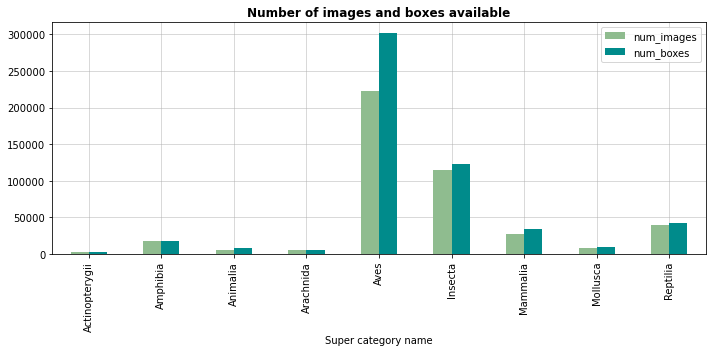

In [3]:
pd.DataFrame({"num_images" : df.drop_duplicates("image_id").groupby("super_category_name").size(),
              "num_boxes" : df.groupby("super_category_name").size()}).plot.bar(figsize = (10,5),
                                                                                zorder = 10,
                                                                                color = ["darkseagreen", "darkcyan"])

plt.title("Number of images and boxes available", fontsize = 12, weight = "bold")
plt.grid(zorder = -10, alpha = 0.6)
plt.xlabel("Super category name")
plt.tight_layout()
plt.savefig("plots/super_categories.pdf", bbox_inches='tight')

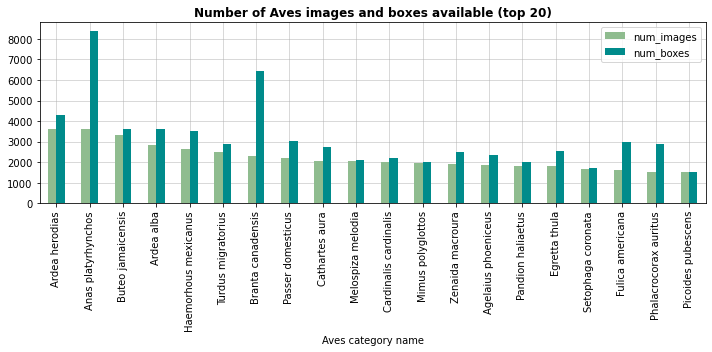

In [4]:
pd.DataFrame({"num_images": df[df.super_category_name == "Aves"].drop_duplicates("image_id").groupby("category_name").size().sort_values(ascending = False).head(20), 
             "num_boxes": df[df.super_category_name == "Aves"].groupby("category_name").size()}).dropna().sort_values("num_images", ascending = False).plot.bar(figsize = (10,5),
                                                                                zorder = 10,
                                                                                color = ["darkseagreen", "darkcyan"])
plt.title("Number of Aves images and boxes available (top 20)", fontsize = 12, weight = "bold")
plt.grid(zorder = -10, alpha = 0.6)
plt.xlabel("Aves category name")
plt.tight_layout()
plt.savefig("plots/20aves.pdf", bbox_inches='tight')

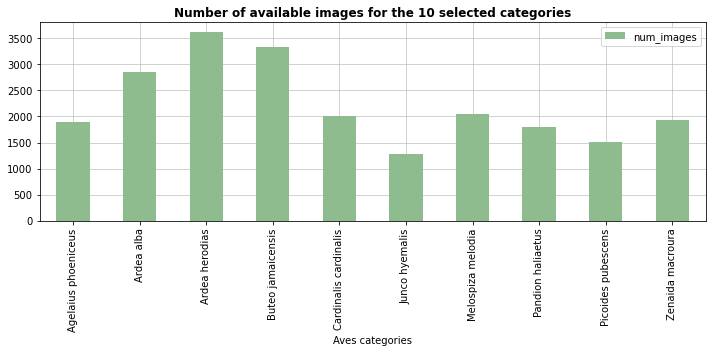

In [5]:
# from the downloaded images

pd.DataFrame({cat:len(os.listdir("Aves"+"/"+cat)) for cat in os.listdir("Aves")},
             index = ["num_images"]).T.sort_index().plot.bar(color = "darkseagreen", figsize = (10, 5), zorder = 10)
plt.title("Number of available images for the 10 selected categories", weight = "bold")
plt.grid(zorder = -10, alpha = 0.7)
plt.xlabel("Aves categories")
plt.tight_layout()
plt.savefig("plots/selected_aves.pdf", bbox_inches='tight')

In [6]:
category_list = os.listdir("Aves")
pd.DataFrame(category_list, columns = ["Category"])

,Category
0,Melospiza melodia
1,Ardea alba
2,Pandion haliaetus
3,Cardinalis cardinalis
4,Zenaida macroura
5,Agelaius phoeniceus
6,Junco hyemalis
7,Ardea herodias
8,Buteo jamaicensis
9,Picoides pubescens


In [7]:
#from SATM.preprocess import clean_aves

In [8]:
img_list = [i for cat in category_list for i in os.listdir("Aves/"+cat)]
print("Example of element in the list:",img_list[0])

Example of element in the list: 959d8aadbbcd72f1938bb162cc7dd10e.jpg


In [9]:
print("Number of available aves images:", len(img_list))

Number of available aves images: 22257


In [10]:
# removing from the dataframe all the pictures for which we haven't downloaded the corresponding file
# ie, images not belonging to the Aves category
df = df[df.identifier.isin(img_list)]
print("Number of available aves boxes:", len(df))

Number of available aves boxes: 25636


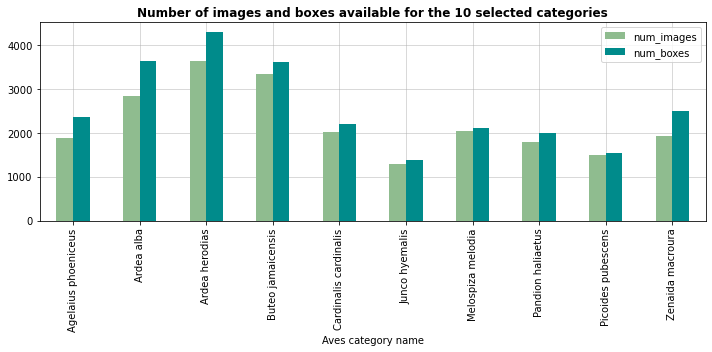

In [11]:
pd.DataFrame({"num_images" : df.drop_duplicates("image_id").groupby("category_name").size(),
              "num_boxes" : df.groupby("category_name").size()}).plot.bar(figsize = (10,5),
                                                                                zorder = 10,
                                                                                color = ["darkseagreen", "darkcyan"])

plt.title("Number of images and boxes available for the 10 selected categories", fontsize = 12, weight = "bold")
plt.grid(zorder = -10, alpha = 0.6)
plt.xlabel("Aves category name")
plt.tight_layout()
plt.savefig("plots/selected_aves_bbox.pdf", bbox_inches='tight')

In [12]:
from SATM.preprocess import encode_df

In [13]:
df = encode_df(df)

In [ ]:
from SATM.